# 5. 단어 임베딩 시각화 및 분석

이 노트북에서는 앞서 학습한 GloVe 단어 임베딩을 시각화하고 분석합니다.

## 학습 목표
- 고차원 임베딩을 2D로 차원 축소하여 시각화하기
- 단어 간 유사도와 의미적 관계 분석하기
- 임베딩 공간의 특성 탐구하기
- 워드 클러스터링 수행하기

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

# 한글 폰트 설정 (설정이 필요한 경우)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("한글 폰트 설정에 실패했습니다. 필요한 경우 시스템에 맞는 폰트를 설정해주세요.")

## 5.1 학습된 임베딩 불러오기

이전 노트북에서 저장한 GloVe 임베딩을 불러옵니다.

In [6]:
# GloVe 임베딩 결과 불러오기
try:
    with open('glove_embeddings_results.pkl', 'rb') as f:
        embeddings_results = pickle.load(f)
    
    center_embeddings = embeddings_results['center_embeddings']
    context_embeddings = embeddings_results['context_embeddings']
    combined_embeddings = embeddings_results['combined_embeddings']
    word_to_id = embeddings_results['word_to_id']
    id_to_word = embeddings_results['id_to_word']
    embedding_dim = embeddings_results['embedding_dim']
    losses = embeddings_results.get('losses', [])
    
    print("GloVe 임베딩 결과를 성공적으로 불러왔습니다.")
    print(f"임베딩 크기: {combined_embeddings.shape}")
    print(f"임베딩 차원: {embedding_dim}")
    print(f"어휘 사전 크기: {len(word_to_id)} 단어")
except FileNotFoundError:
    print("GloVe 임베딩 결과 파일을 찾을 수 없습니다. 먼저 '4_glove_loss_implementation.ipynb'를 실행해주세요.")

GloVe 임베딩 결과를 성공적으로 불러왔습니다.
임베딩 크기: (59, 50)
임베딩 차원: 50
어휘 사전 크기: 59 단어


## 5.2 임베딩 품질 평가

학습 손실 곡선을 다시 시각화하고, 임베딩의 기본 통계량을 확인합니다.

In [12]:
!pip install koreanize_matplotlib
import koreanize_matplotlib


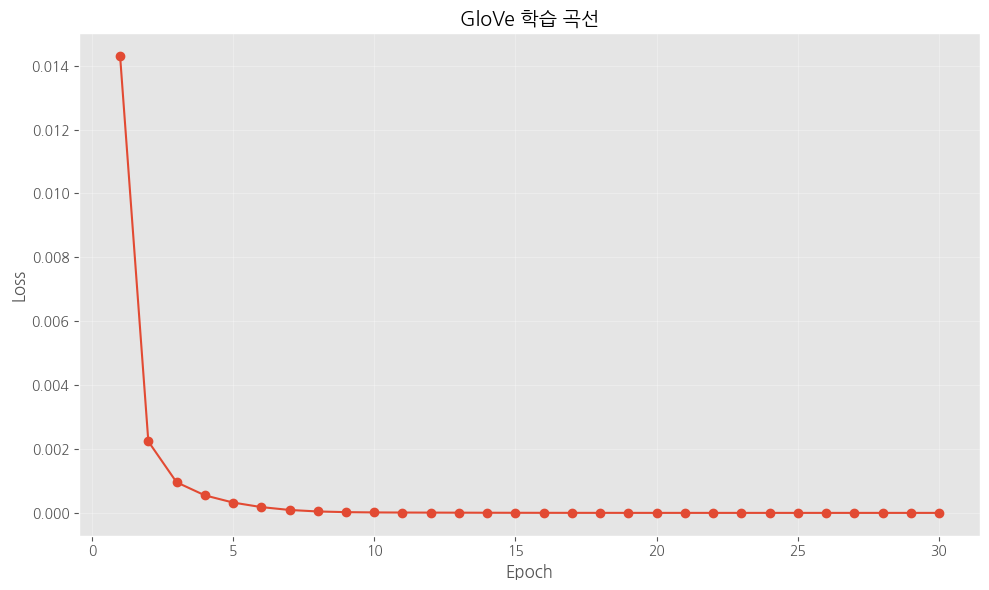

임베딩 통계:
평균 노름: 1.4327
표준편차 노름: 0.1127
최소 노름: 1.1159
최대 노름: 1.7085


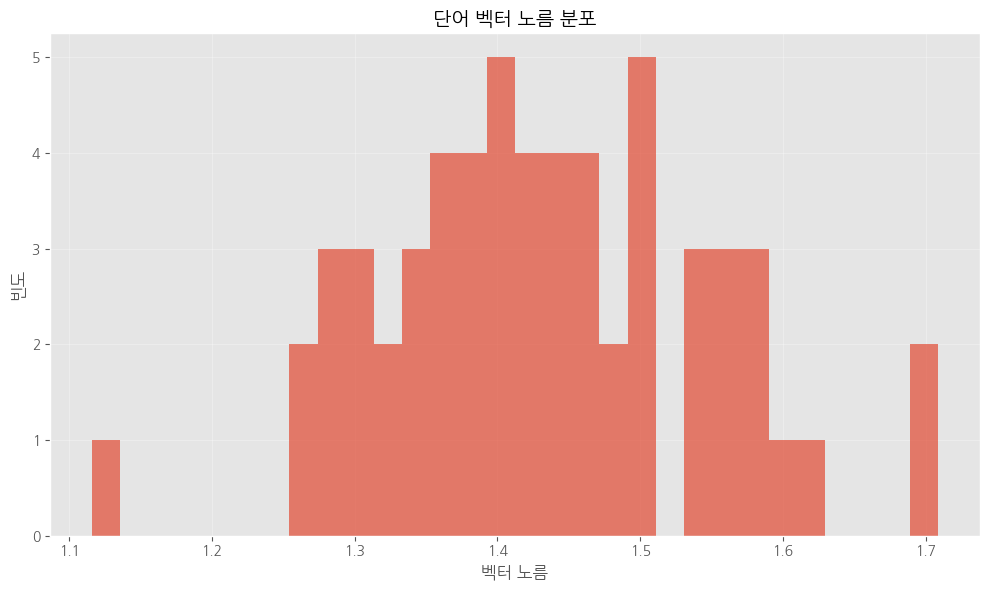

In [13]:
# 학습 손실 곡선 시각화 (손실 데이터가 있는 경우)
if losses:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses)+1), losses, marker='o')
    plt.title('GloVe 학습 곡선', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 임베딩 통계량 확인
norms = np.linalg.norm(combined_embeddings, axis=1)

print("임베딩 통계:")
print(f"평균 노름: {np.mean(norms):.4f}")
print(f"표준편차 노름: {np.std(norms):.4f}")
print(f"최소 노름: {np.min(norms):.4f}")
print(f"최대 노름: {np.max(norms):.4f}")

# 노름 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(norms, bins=30, alpha=0.7)
plt.title('단어 벡터 노름 분포', fontsize=14)
plt.xlabel('벡터 노름', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5.3 PCA를 사용한 차원 축소 및 시각화

주성분 분석(PCA)을 사용하여 고차원 임베딩을 2D로 축소하고 시각화합니다.

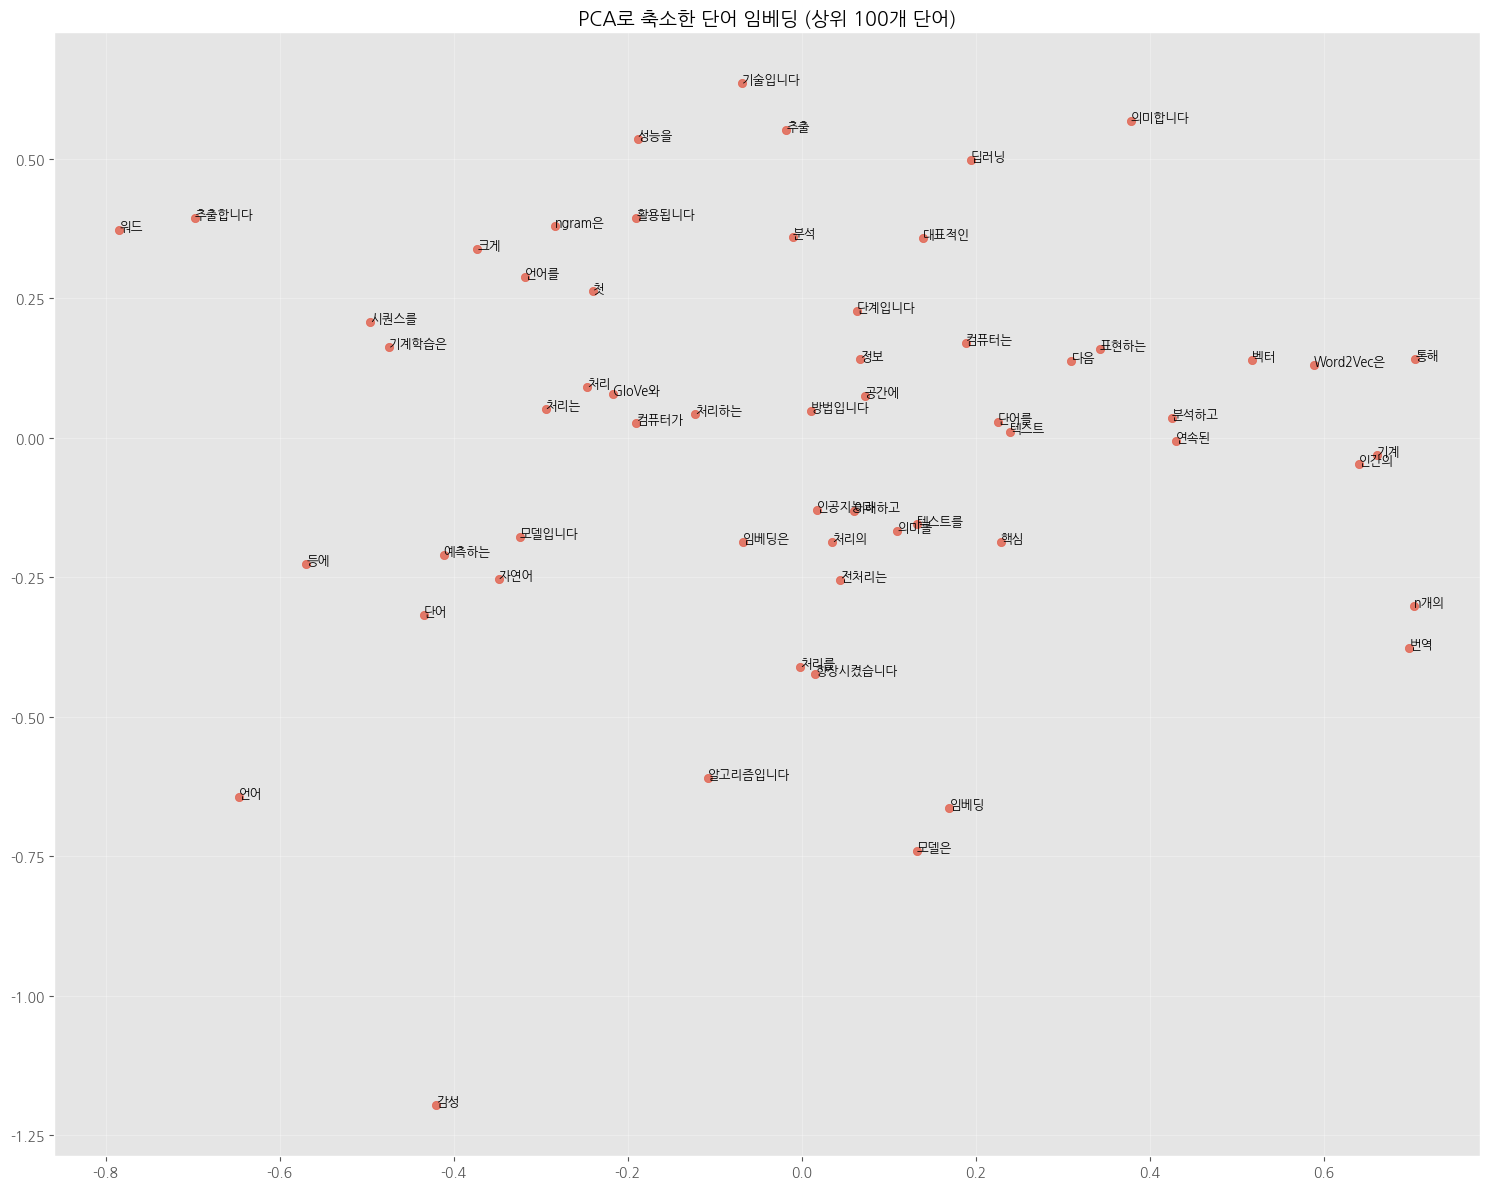

In [15]:
def reduce_dimensions_pca(embeddings, n_components=2):
    """PCA를 사용하여 임베딩 차원 축소"""
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

def visualize_embeddings_2d(embeddings_2d, words, title, figsize=(15, 12), max_words=100, annotate=True):
    """2D 임베딩 시각화"""
    plt.figure(figsize=figsize)
    
    # 표시할 단어 수 제한
    n_words = min(len(words), max_words)
    
    # 산점도
    plt.scatter(embeddings_2d[:n_words, 0], embeddings_2d[:n_words, 1], alpha=0.7)
    
    # 단어로 주석 달기
    if annotate:
        for i in range(n_words):
            plt.annotate(words[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)
    
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 자주 사용되는 단어 선택 (상위 100개)
most_common_words = [word for word, _ in sorted(word_to_id.items(), key=lambda x: word_to_id[x[0]])[:100]]
most_common_ids = [word_to_id[word] for word in most_common_words]

# PCA로 차원 축소
embeddings_pca = reduce_dimensions_pca(combined_embeddings[:100])

# 시각화
visualize_embeddings_2d(embeddings_pca, most_common_words, "PCA로 축소한 단어 임베딩 (상위 100개 단어)")

## 5.4 t-SNE를 사용한 차원 축소 및 시각화

t-SNE는 고차원 데이터의 비선형 구조를 더 잘 보존하는 차원 축소 기법입니다.

t-SNE 차원 축소 중... (시간이 다소 걸릴 수 있습니다)


/Users/martin/.asdf/installs/python/3.10.15/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


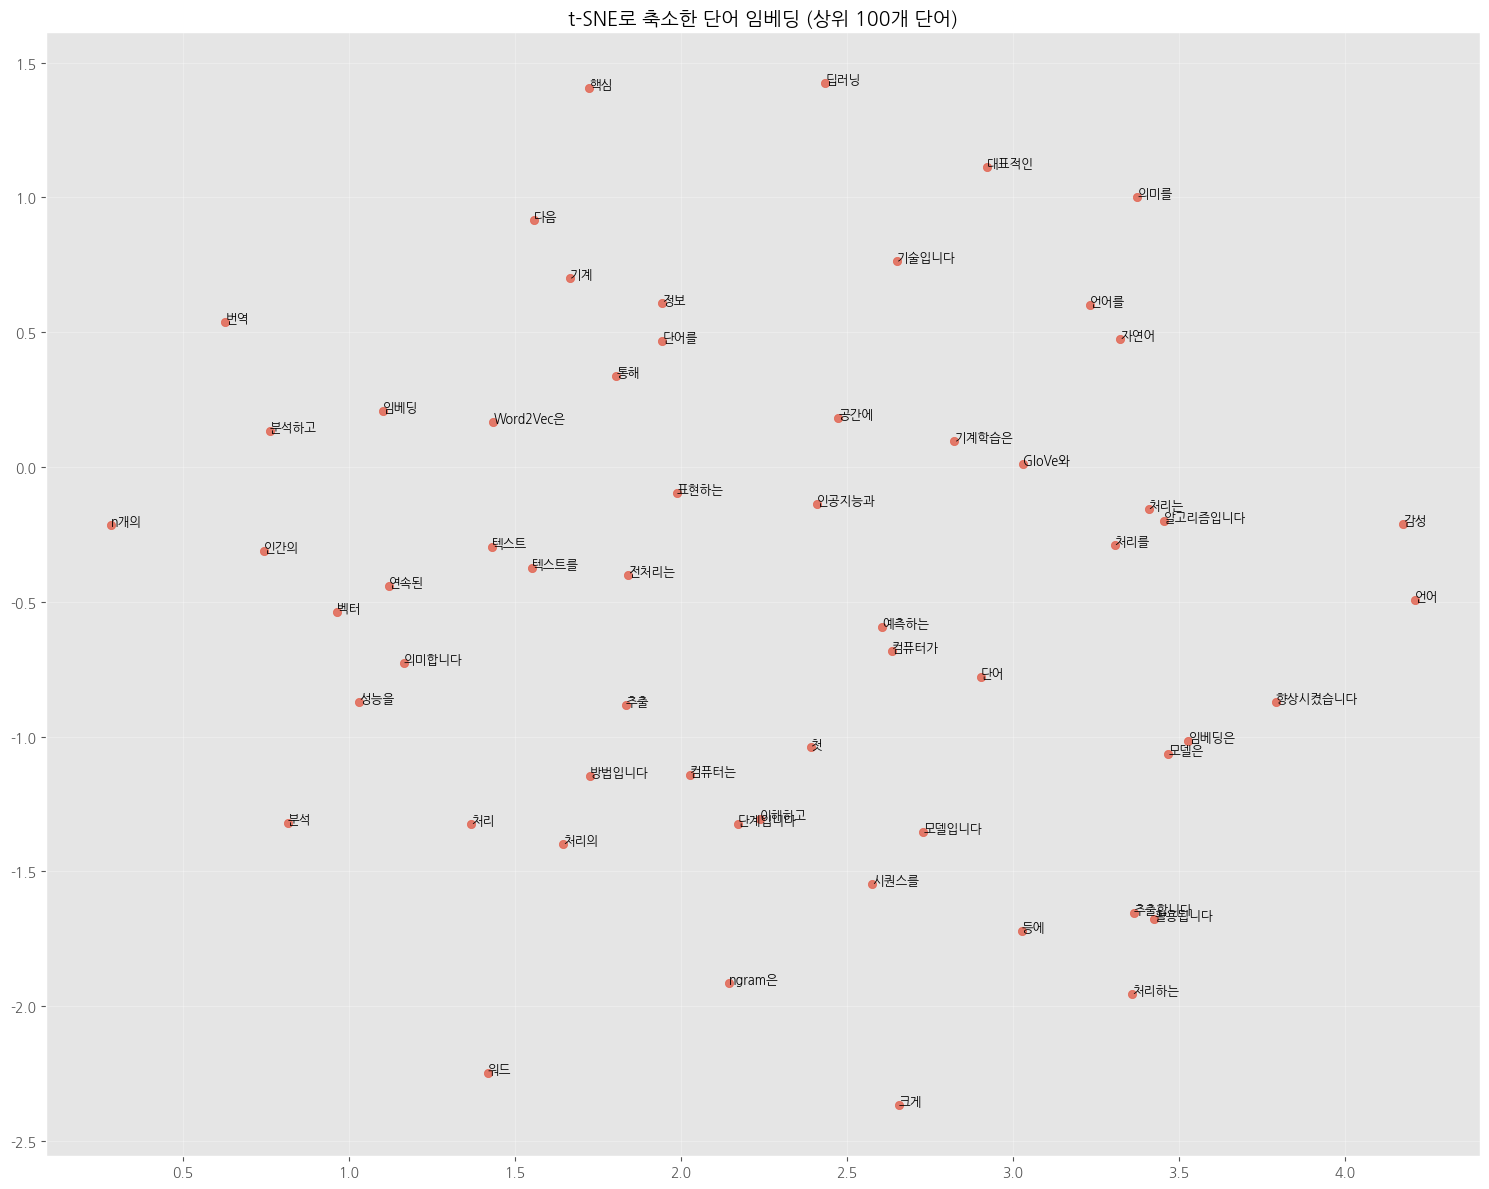

In [16]:
def reduce_dimensions_tsne(embeddings, n_components=2, perplexity=30, n_iter=1000):
    """t-SNE를 사용하여 임베딩 차원 축소"""
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    return tsne.fit_transform(embeddings)

# t-SNE로 차원 축소 (시간이 오래 걸릴 수 있음)
print("t-SNE 차원 축소 중... (시간이 다소 걸릴 수 있습니다)")
embeddings_tsne = reduce_dimensions_tsne(combined_embeddings[:100])

# 시각화
visualize_embeddings_2d(embeddings_tsne, most_common_words, "t-SNE로 축소한 단어 임베딩 (상위 100개 단어)")

## 5.5 단어 클러스터링

임베딩 공간에서 비슷한 단어들을 클러스터링(군집화)합니다.

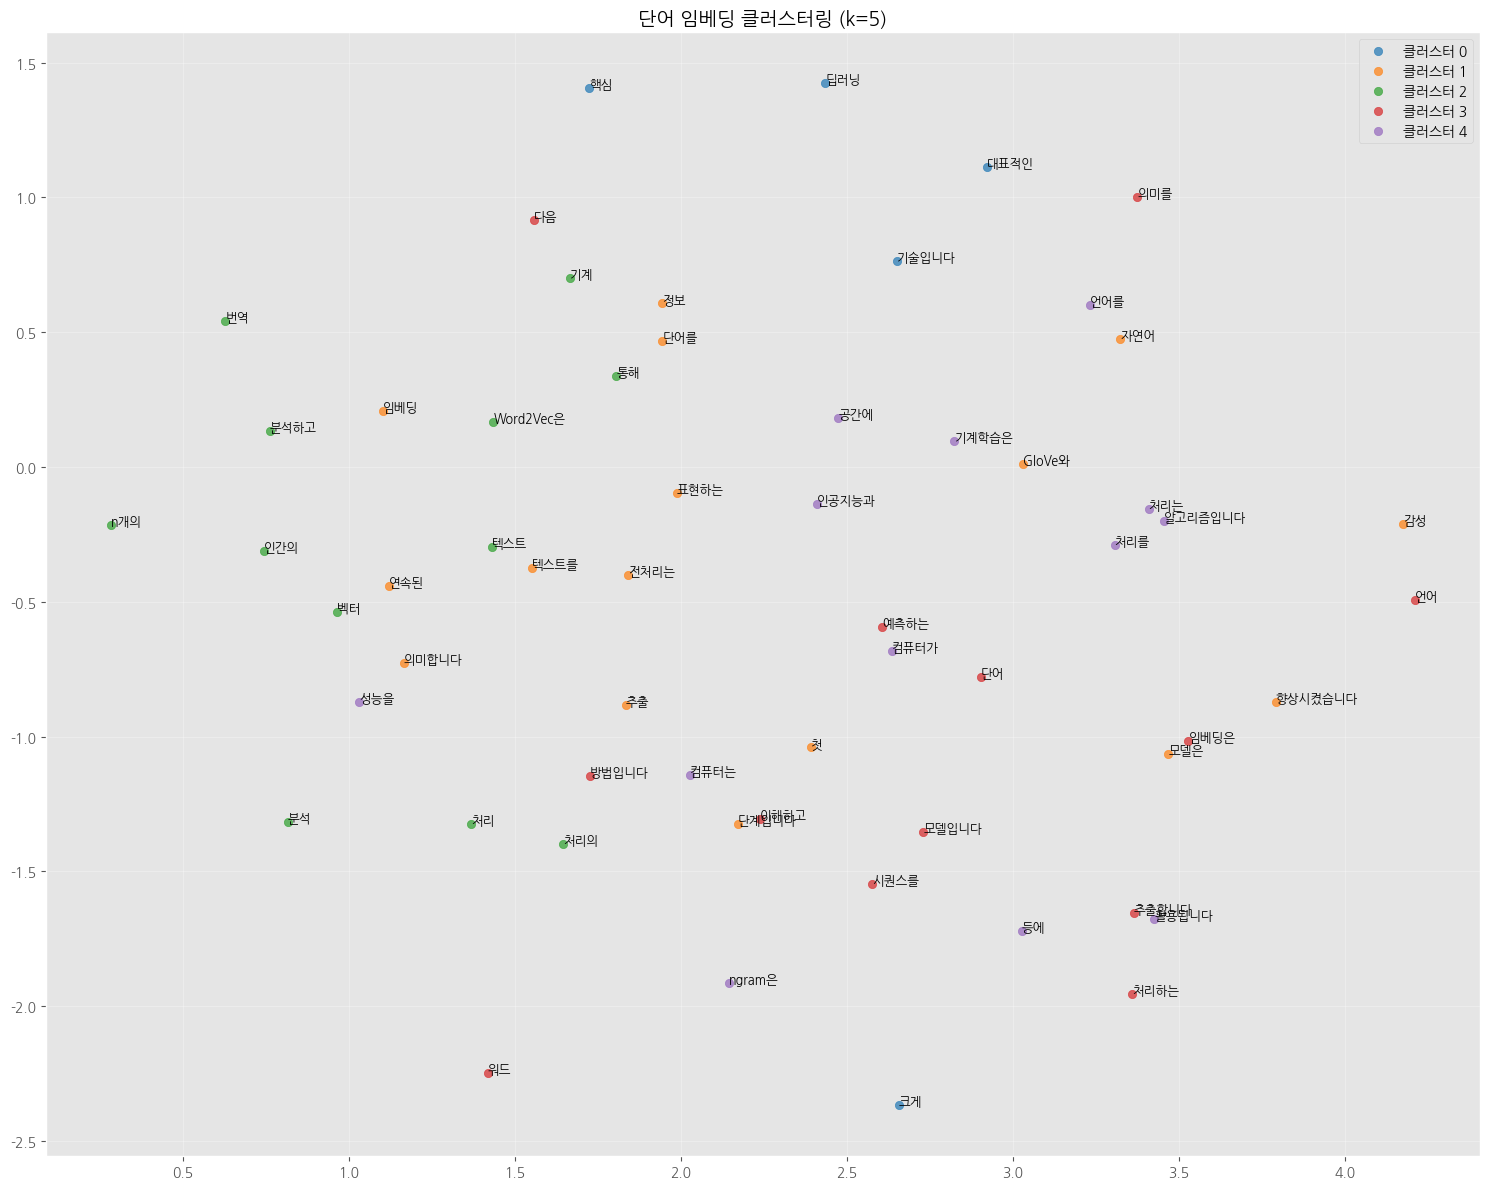


클러스터링 결과 (k=5):
클러스터 0: 기술입니다, 핵심, 딥러닝, 크게, 대표적인
클러스터 1: 자연어, 모델은, 단어를, 텍스트를, 향상시켰습니다, 표현하는, GloVe와, 임베딩, 연속된, 의미합니다...
클러스터 2: 처리의, 인간의, 통해, 분석하고, 처리, 벡터, Word2Vec은, n개의, 기계, 번역...
클러스터 3: 워드, 이해하고, 처리하는, 의미를, 추출합니다, 임베딩은, 방법입니다, 언어, 다음, 예측하는...
클러스터 4: 처리는, 컴퓨터가, 언어를, 컴퓨터는, 처리를, 인공지능과, 기계학습은, 성능을, 공간에, 알고리즘입니다...


In [17]:
def cluster_words(embeddings, n_clusters=5):
    """단어 임베딩 클러스터링"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(embeddings)

def visualize_word_clusters(embeddings_2d, words, clusters, title, figsize=(15, 12)):
    """클러스터링 결과 시각화"""
    plt.figure(figsize=figsize)
    
    # 색상 맵
    colors = plt.cm.tab10.colors
    
    # 유니크한 클러스터 ID
    unique_clusters = np.unique(clusters)
    
    for cluster_id in unique_clusters:
        # 해당 클러스터에 속하는 단어 인덱스
        indices = np.where(clusters == cluster_id)[0]
        
        # 클러스터 데이터 포인트
        cluster_points = embeddings_2d[indices]
        
        # 산점도
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    color=colors[cluster_id % len(colors)],
                    alpha=0.7, label=f'클러스터 {cluster_id}')
        
        # 단어로 주석 달기
        for idx in indices:
            plt.annotate(words[idx], (embeddings_2d[idx, 0], embeddings_2d[idx, 1]), fontsize=9)
    
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 가장 빈번한 단어 100개 선택 (또는 원하는 다른 단어 셋)
selected_words = most_common_words[:100]
selected_ids = [word_to_id[w] for w in selected_words]
selected_embeddings = combined_embeddings[selected_ids]

# 클러스터링 수행
n_clusters = 5  # 클러스터 수 (필요에 따라 조정)
clusters = cluster_words(selected_embeddings, n_clusters)

# 클러스터링 결과 시각화 (앞서 계산한 t-SNE 결과 활용)
visualize_word_clusters(embeddings_tsne, selected_words, clusters, 
                       f"단어 임베딩 클러스터링 (k={n_clusters})")

# 클러스터별 단어 출력
print(f"\n클러스터링 결과 (k={n_clusters}):")
for cluster_id in range(n_clusters):
    indices = np.where(clusters == cluster_id)[0]
    cluster_words = [selected_words[idx] for idx in indices]
    print(f"클러스터 {cluster_id}: {', '.join(cluster_words[:10])}" + 
          ("..." if len(cluster_words) > 10 else ""))

## 5.6 단어 간 유사도 분석

특정 단어와 가장 유사한 단어들을 찾아봅니다.

In [18]:
def find_similar_words(word, embeddings, word_to_id, id_to_word, top_n=5):
    """특정 단어와 가장 유사한 단어들을 찾는 함수"""
    if word not in word_to_id:
        print(f"단어 '{word}'를 어휘 사전에서 찾을 수 없습니다.")
        return []
    
    word_id = word_to_id[word]
    word_vec = embeddings[word_id]
    
    # 벡터 정규화
    word_vec_norm = np.linalg.norm(word_vec)
    if word_vec_norm > 0:
        word_vec = word_vec / word_vec_norm
    
    # 모든 단어 벡터 정규화
    embeddings_norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
    embeddings_norm[embeddings_norm == 0] = 1  # 0으로 나누기 방지
    normalized_embeddings = embeddings / embeddings_norm
    
    # 코사인 유사도 계산
    similarities = np.dot(normalized_embeddings, word_vec)
    
    # 유사도가 높은 상위 단어 ID (자기 자신 제외)
    most_similar_ids = []
    sorted_ids = np.argsort(similarities)[::-1]
    
    for idx in sorted_ids:
        if idx != word_id:  # 자기 자신 제외
            most_similar_ids.append(idx)
            if len(most_similar_ids) >= top_n:
                break
    
    # 결과 생성
    result = []
    for idx in most_similar_ids:
        result.append((id_to_word[idx], similarities[idx]))
    
    return result

# 예시: 몇 가지 단어에 대해 유사 단어 탐색
example_words = most_common_words[:5]  # 상위 5개 단어
for word in example_words:
    similar_words = find_similar_words(word, combined_embeddings, word_to_id, id_to_word, top_n=5)
    print(f"\n'{word}'와 가장 유사한 단어들:")
    for similar_word, similarity in similar_words:
        print(f"  {similar_word}: {similarity:.4f}")


'자연어'와 가장 유사한 단어들:
  대표적인: 0.2326
  언어를: 0.2287
  언어: 0.1933
  예측하는: 0.1816
  알고리즘입니다: 0.1786

'처리는'와 가장 유사한 단어들:
  알고리즘입니다: 0.3170
  ngram은: 0.2569
  처리를: 0.2186
  GloVe와: 0.2022
  기계학습은: 0.1782

'기술입니다'와 가장 유사한 단어들:
  기계학습은: 0.3421
  활용됩니다: 0.2634
  통해: 0.2419
  Word2Vec은: 0.2388
  언어를: 0.2222

'처리의'와 가장 유사한 단어들:
  처리하는: 0.2129
  방법입니다: 0.2029
  처리: 0.1835
  자연어: 0.1777
  컴퓨터가: 0.1374

'모델은'와 가장 유사한 단어들:
  등에: 0.2415
  단어: 0.2288
  알고리즘입니다: 0.2123
  컴퓨터가: 0.1988
  n개의: 0.1919


## 5.7 요약 및 결론

이 노트북에서는 GloVe로 학습한 단어 임베딩을 시각화하고 분석했습니다. 주요 단계는 다음과 같습니다:

1. 임베딩 품질 평가 및 기본 통계 확인
2. PCA와 t-SNE를 사용한 차원 축소 및 시각화
3. K-means를 사용한 단어 클러스터링
4. 단어 간 유사도 분석

분석 결과를 통해 다음과 같은 통찰을 얻을 수 있습니다:

1. 의미적으로 유사한 단어들은 임베딩 공간에서 서로 가깝게 위치합니다.
2. 단어 벡터는 단어 간의 의미적 관계를 포착하며, 이를 통해 유사도를 계산할 수 있습니다.
3. 클러스터링을 통해 유사한 의미를 가진 단어 그룹을 자동으로 찾을 수 있습니다.

GloVe 모델은 단어의 동시출현 통계를 기반으로 학습하므로, 충분한 양의 텍스트 데이터가 있을 때 더 좋은 품질의 임베딩을 얻을 수 있습니다.

## 연습 문제

1. 다양한 t-SNE 하이퍼파라미터(perplexity, n_iter 등)를 시도하여 최적의 시각화 결과를 찾아보세요.
2. 다른 클러스터링 알고리즘(예: DBSCAN, 계층적 클러스터링)을 시도하고 결과를 비교해보세요.
3. 특정 주제와 관련된 단어들의 임베딩 공간 내 분포를 분석하고 해석해보세요.
4. 단어 벡터 연산을 통해 단어 간의 의미적 관계를 탐색해보세요 (예: '왕 - 남자 + 여자 = ?').